<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Семинар 2: практическое занятие по обучению нейросетей (датасет notMNIST)</b></h2>

---

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch

import torchvision
from torchvision import transforms
from PIL import Image

---

#### Если вы работаете в Google Colab,  запустите следующие две клетки

In [3]:
!pip install --no-cache-dir -I pillow

     |████████████████████████████████| 3.0MB 9.7MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [4]:
!pip3 install wheel==0.34.1

In [5]:
# http://pytorch.org/
from os.path import exists

from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl
  ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl because of error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl


Также, если вы работаете в colab, вам придётся загрузить в него notMNIST.
Это можно сделать например так:

- Скачать оба архива по ссылке ниже
- Загрузить их на colab, исполнив следующую клетку
- Распаковать их, исполнив код в клетке за ней

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving notMNIST_train.zip to notMNIST_train (1).zip
Saving notMNIST_val.zip to notMNIST_val.zip
User uploaded file "notMNIST_train.zip" with length 10486682 bytes
User uploaded file "notMNIST_val.zip" with length 2088542 bytes


In [11]:
 !unzip -q notMNIST_val.zip
 !unzip -q notMNIST_train.zip
 !ls

 __MACOSX	 'notMNIST_train (1).zip'   notMNIST_val       sample_data
 notMNIST_train   notMNIST_train.zip	    notMNIST_val.zip


---

Сейчас мы будем работать с датасетом под названием notMNIST. Это задача классификации на 10 классов (как и в обычном MNIST), то только классы здесь -- не цифры от 0 до 9, в буквы латинского алфавита от **A** до **J**

Данные, уже разбитые на train и val, лежат здесь: https://drive.google.com/drive/u/2/folders/1d_Wca5S60SM8qHqpkwqGuBK54vLYi7pa

In [12]:
classes = os.listdir("./notMNIST_train")

In [13]:
n_classes = len(classes)
classes = sorted(classes)
classes

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

Все изображения букв имеют размер 28$\times$28. Давайте вынесем высоту и ширину картинок в константные переменные:

In [14]:
IMG_H = 28
IMG_W = 28

Чтобы облегчить себе работу, воспользуемся загрузчиком датасетов, втроенном в torch. Если у нас стоит задача классификации на N классов, и тренировочные данные дежат в отдельной папке (у нас это notMNIST_train), и внутри папки картинки каждого класса лежат в отдельной папке с названием класса, то мы можем загрузить данные в память компьютера для того чтобы дальше подавать эти данные на вход сети, используя torchvision.datasets.ImageFolder. 

На вход torchvision.datasets.ImageFolder нужно подать название папки с данными (т.е. notMNIST_train в нашем случае) и преобразования, которые необходимо применить к изображениям в папке, прежде чем сформировать из них датасет (например, если изображения в папке разных размеров, их нужно привести к одному размеру. Мы же будем переводить картинки из rgb в черно-белый формат и конвертировать их в tensor для более простой работы с ними при обучении нейронной сети).

После этого останется обернуть объект, который вернет torchvision.datasets.ImageFolder, в data_utils.DataLoader, и мы получим на выходе объект (ниже в коде это переменная train_loader), который будет генерировать нам мини-батчи данных. Не надо писать генерацию мини-батчей из данных руками!

In [15]:
batch_size = 64

train_data = torchvision.datasets.ImageFolder('./notMNIST_train/', transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])
    )
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = torchvision.datasets.ImageFolder('./notMNIST_val/', transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])
    )
val_loader = data_utils.DataLoader(val_data, batch_size=1, shuffle=False)

Давайте помотрим, как выглядят наши картинки:

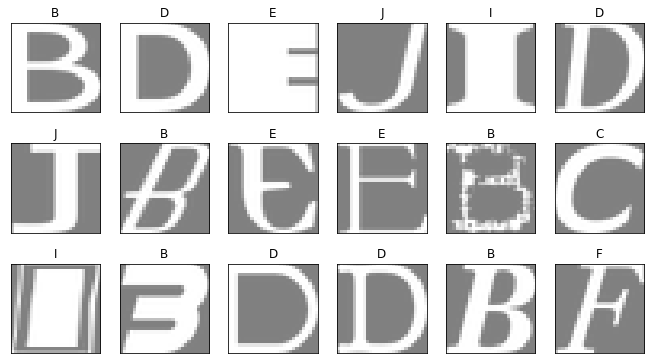

In [16]:
def plot_gallery(images, labels, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.title(labels[i])
        plt.imshow(images[i].numpy().reshape((28, 28)), cmap=plt.cm.gray, vmin=-1, vmax=1)
        plt.xticks(())
        plt.yticks(())



# достаем случайные картинки из обучающей выборки
dataiter = iter(train_loader)
images, labels = dataiter.next()

# вызываем функцию, реализующую демонстрацию изображений, что мы можем видеть на них?
plot_gallery(images, [classes[labels[j]] for j in range(len(images))], IMG_H, IMG_W)

Ну, выборка готова, теперь зададим архитектуру сети:

In [17]:
hid_size = 100
out_size = n_classes

class TwoLayerNet(nn.Module):
    def __init__(self, h, w, hid_size, out_size):
        super(TwoLayerNet, self).__init__()
        # объявляем слои для нашей сети
        self.linear1 = nn.Linear(h*w, hid_size)
        self.linear2 = nn.Linear(hid_size, out_size)

    def forward(self, x):
        
        x = self.linear1(x)
        # функция активации
        x = F.relu(x)
        x = self.linear2(x)
        return x
    
two_layer_net = TwoLayerNet(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)

В качестве лосса для нашей многоклассовой классификации опять же возьмем кросс-энтропию:

https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss

In [18]:
loss_fn = torch.nn.CrossEntropyLoss()

Теперь зададим learning rate и оптимизатор -- знакомый нам SGD

In [19]:
learning_rate = 1e-3
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

И, наконец, функция непосредственно обучения сети:

При обучении сети после каждой эпохи будем измерять не только полученный лосс на валидации (кросс-энтропию), но и accuracy. Зачем? Потому что человеку, глядя только на значение кросс-энтропии, сложно понять, насколько "хорошо" на самом деле сетка себя ведет. Глядя на accuracy, это понять намного легче =)

In [20]:
from IPython import display
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def train(train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []

    train_acc = []
    val_acc = []

    for epoch in tqdm(range(num_epochs)):
        display.clear_output(wait=True)
        
        # 1. forward
        two_layer_net.train(True)
        loss_batch = []
        acc_batch = []
        for x_train, y_train in train_loader:
            x_train = Variable(x_train.view(x_train.shape[0], -1))
            # 1.1 получаем предсказания сети
            <тут ваш код>
            # 1.2 вычисляем accuracy на данном батче по предсказаниями и правильным ответам
            <тут ваш код>
            # 1.3 вычисляем loss (кросс-эетропию)
            <тут ваш код>
            # 1.4 backward
            <тут ваш код>
            # 1.5 обновляем
            <тут ваш код>
            # 1.6 зануляем
            <тут ваш код>
            # 1.7 запоминаем 
            <тут ваш код>

        train_losses.append(np.mean(loss_batch))
        train_acc.append(np.mean(acc_batch))

        # 2. val
        two_layer_net.train(False)
        loss_batch = []
        acc_batch = []
        for i, (x_val, y_val) in enumerate(val_loader):
            x_val = Variable(x_val.view(x_val.shape[0], -1))
            # 2.1 получаем предсказания сети
            <тут ваш код>
            # 2.2 вычисляем accuracy на данном батче по предсказаниями и правильным ответам
            <тут ваш код>
            # 2.3 вычисляем loss (кросс-эетропию)
            <тут ваш код>
            # 2.4 запоминаем 
            <тут ваш код>

        val_losses.append(np.mean(loss_batch))
        val_acc.append(np.mean(acc_batch))

        # 3. будем сохранять модель в файл, если после этой эпохи loss упал
        <тут ваш код>

        # 4. show plot
        <тут ваш код>

        plt.title("losses")
        axes[0].plot(train_losses, label="train loss")
        axes[0].plot(val_losses, label="val loss")
        plt.legend()

        plt.title("accuracies")
        axes[1].plot(train_acc, label="train accuracy")
        axes[1].plot(val_acc, label="val accuracy")
        plt.legend()

        plt.show() 
        
    print("Final loss: ", val_losses[-1])
    print("Final accuracy: ", val_acc[-1])

SyntaxError: ignored

In [21]:
train(train_loader, val_loader, num_epochs=20)

NameError: ignored

Давайте теперь вспомним, что SGD -- не единственный оптимизатор, который мы знаем. Есть еще куча -- RMSprop, Adam, Adadelta, Adagrad...

На данный момент самым лучшим (в плане скорости сходимости) считается Adam. Давайте попробуем заменить для нашей сети SGD на Adam:

In [22]:
two_layer_net = TwoLayerNet(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(two_layer_net.parameters(), lr=learning_rate)

In [23]:
train(train_loader, val_loader, num_epochs=10)

NameError: ignored

Хм, сильное переобучение. Как с этим бороться? Например, можно уменьшить learning rate, тогда веса будут обновляться "аккуратнее", и обучение будет более стабильным. Давайте попробуем!

In [ ]:
two_layer_net = TwoLayerNet(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate=1e-4
optimizer = torch.optim.Adam(two_layer_net.parameters(), lr=learning_rate)

In [ ]:
train(train_loader, val_loader, num_epochs=20)

Как видим, за те же 20 эпох Adam обучился на 5% качества лучше, чем SGD, хотя мы не занимались жестким подбором параметров (learning rate, например). Хотя небольшое переобучение все же имеет место. Можно поиграться с разными оптимайзерами и learning_rate'ми и посмотреть, что будет =)

In [ ]:
---

### Dropout

In [ ]:
hid_size = 100
out_size = n_classes

class ThreeLayerNet(nn.Module):
    def __init__(self, h, w, hid_size, out_size):
        super(ThreeLayerNet, self).__init__()
        # объявляем слои для нашей сети
        self.linear1 = nn.Linear(h*w, hid_size)
        self.dropout1 = nn.Dropout(0.1)
#         self.batch_norm1 = nn.BatchNorm1d(hid_size)
        
        self.linear2 = nn.Linear(hid_size, hid_size)
        self.dropout2 = nn.Dropout(0.1)
#         self.batch_norm2 = nn.BatchNorm1d(hid_size)
       
        self.linear3 = nn.Linear(hid_size, out_size)

    def forward(self, x):
        
        x = self.linear1(x)
        # функция активации
        x = F.relu(x)
        x = self.dropout1(x)
#         x = self.batch_norm1(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.dropout2(x)
#         x = self.batch_norm2(x)
        x = self.linear3(x)
        return x
    
# two_layer_net = TwoLayerNet(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)

In [ ]:
two_layer_net = ThreeLayerNet(h=IMG_H, w=IMG_W, hid_size=20, out_size=out_size)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate=1e-3
optimizer = torch.optim.Adam(two_layer_net.parameters(), lr=learning_rate)

In [ ]:
train(train_loader, val_loader, num_epochs=20)

### Batch Normalization (BatchNorm) (будет подробнее позже, тут лишь небольшой пример)

In [ ]:
hid_size = 100
out_size = n_classes

class TwoLayerNet_BN(nn.Module):
    def __init__(self, h, w, hid_size, out_size):
        super(TwoLayerNet_BN, self).__init__()
        # объявляем слои для нашей сети
        self.linear1 = nn.Linear(h*w, hid_size)
        self.dropout1 = nn.Dropout(0.2)
        self.batch_norm1 = nn.BatchNorm1d(hid_size)
        
        self.linear2 = nn.Linear(hid_size, hid_size)
        self.dropout2 = nn.Dropout(0.2)
        self.batch_norm2 = nn.BatchNorm1d(hid_size)
       
        self.linear3 = nn.Linear(hid_size, out_size)

    def forward(self, x):
        
        x = self.linear1(x)
        # функция активации
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.batch_norm1(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.batch_norm2(x)
        x = self.linear3(x)
        return x
    
# two_layer_net = TwoLayerNet(h=IMG_H, w=IMG_W, hid_size=hid_size, out_size=out_size)

In [ ]:
two_layer_net = TwoLayerNet_BN(h=IMG_H, w=IMG_W, hid_size=20, out_size=out_size)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate=5e-4
optimizer = torch.optim.Adam(two_layer_net.parameters(), lr=learning_rate)

In [ ]:
train(train_loader, val_loader, num_epochs=20)